# A Simple Autoencoder using Hi-C data

## 0. Hi-C class

In [364]:
"""
.. module:: Hic
   :synopsis: This module implements the matrix class.
"""

# Third-party modules
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import random as rd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random as rd
%matplotlib inline

reds = cm.get_cmap('Reds', 300)
white = np.array([1, 1, 1, 1])
newcmp = ListedColormap(np.vstack((white, reds(np.linspace(0, 1, 300)))))

class Hic:
    """
    .. class:: Hic
        This class groups informations about a Hi-C matrix.

    Attributes:
        sparse (Pandas DataFrame): A data frame containing the Hi-C sparse matrix.
        resolution (int): The resolution of the matrix.
        size (int):
        matrix (numpy array):
    """

    def __init__(self, filename, resolution):
        self.df = pd.read_csv(filename, sep='\t', header=None)
        self.df.columns = ['chr', 'base_1', 'base_2', 'value']
        self.resolution = resolution
        self.end = int(max(self.df['base_2']))
        self.size = int(self.end / self.resolution)
        self.matrix = None
        self.sub_matrices = None

    def set_matrix(self):
        """
            Create a sparse matrix in a very fast way using scipy.sparse module
            and convert it into a numpy array.
        """
        # All the values are stored in a numpy array
        # The matrix will be symetric, so the values must be added twice
        values = self.df.value
        data = np.array(values.append(values))
        # base_1 and base_2 columns must be converted to index by dividing by the resolution number
        # This step is necesary for the creation of the sparse matrix with scipy.sparse
        base_1_index = ((self.df.base_1 / self.resolution)+1).astype(int)
        base_2_index = ((self.df.base_2 / self.resolution)+1).astype(int)
        row = np.array(base_1_index.append(base_2_index))
        col = np.array(base_2_index.append(base_1_index))
        # Creation of the sparse matrix and conversion into a numpy array
        self.matrix = coo_matrix((data, (row, col)), shape=(self.size+2, self.size+2)).toarray()
        # Conversion in float32 format
        self.matrix = np.float32(self.matrix)
        # Logarithmic rescale
        self.matrix = np.log(self.matrix+1)
        # Rescaling of the values in range 0-1
        # (min-max scaling method)
        self.matrix = (self.matrix - self.matrix.min()) / (self.matrix.max() - self.matrix.min())
        # other method :
        # self.matrix = self.matrix / self.matrix.max()

    def print_matrix_informations(self):
        print("Shape of the Hi-C sparse matrix : {}*{}."
            .format(self.matrix.shape[0], self.matrix.shape[1]))
        print("Chromosome(s) : {}".format(", ".join(h.df.chr.unique())))
        print("Min={}, Max={}, Mean={:.2}"
            .format(self.matrix.min(), self.matrix.max(), self.matrix.mean()))

    def plot_matrix(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.set_title('Hi-C matrix plot')
        im = ax.matshow(self.matrix, cmap=newcmp)
        fig.colorbar(im)

    def set_sub_matrices(self, nrow, ncol, nele=1):
        """
            Reshape of the sparse matrix in order to obtain N matrices of size nrow*ncol.

            Args:
                nrow (int): Number of rows for a sub-matrix
                ncol (int): Number of columns a sub-matrix
                nele (int): Number of element in a list (Default=1)
        """
        #self.sub_matrices = self.matrix.reshape(-1, nrow, ncol, nele)
        # Another less fancy method
        sub_matrices_list = []
        for i in range(0, self.matrix.shape[1], nrow):
            for j in range(0, self.matrix.shape[1], ncol):
                sub_matrix = self.matrix[i:i+nrow, j:j+ncol]
                sub_matrices_list.append(sub_matrix)
        self.sub_matrices = np.array(sub_matrices_list)
        self.sub_matrices = self.sub_matrices.reshape(-1, nrow, ncol, nele)

    def remove_white_sub_matrices(self):
        all_without_white = []
        for i in range(0, self.sub_matrices.shape[0]):
            if self.sub_matrices[i].sum() != 0:
                all_without_white.append(i)
        self.sub_matrices = self.sub_matrices[all_without_white]

    def print_sub_matrices_informations(self):
        print("{} sub-matrices of shape : {}*{}*{}"
            .format(self.sub_matrices.shape[0], self.sub_matrices.shape[1], self.sub_matrices.shape[2], self.sub_matrices.shape[3]))

    def plot_ten_sub_matrices(self):
        print("10 random sub-matrices :")
        plt.figure(figsize=(22, 4))
        for i in range(10):
            plt.subplot(2, 10, i+1)
            random_number = rd.randint(0, self.sub_matrices.shape[0]-1)
            # img_random = rd.randint(0, h.sub_matrices.shape[0])
            plt.imshow(self.sub_matrices[random_number, ..., 0], cmap=newcmp)
            plt.title("submatrix n°{}".format(random_number))

    def get_value(self, chr_num, base_1, base_2):
        """
            Search in a Pandas Dataframe (the Hi-C/NGS matrix) the unique row described
            by two given nucleotide bases and return the value corresponding.

            Args:
                chr_num (str): Name pf the chromosome.
                base_1 (int): Index of the first nucleotide base.
                base_2 (int): Index of the second nucleotide base.
            Returns:
                float: The corresponding value if the row exists or 0 if not.
        """
        # The row could be find by two combinations (base_1 base_2 or base_2 base_1)
        if not isinstance(base_1, int) or not isinstance(base_2, int):
            raise TypeError("Args must be integer.")

        filtered_matrix_1 = self.df[(self.df['chr'] == chr_num) &
                                    (self.df['base_1'] == base_1) &
                                    (self.df['base_2'] == base_2)]
        filtered_matrix_2 = self.df[(self.df['chr'] == chr_num) &
                                    (self.df['base_1'] == base_2) &
                                    (self.df['base_2'] == base_1)]

        # The row do exist in one of the two filtered data frames :
        if not filtered_matrix_1.empty:
            return float(filtered_matrix_1['value'])
        elif not filtered_matrix_2.empty:
            return float(filtered_matrix_2['value'])
        # The row does not exist :
        return 0

## 1. Loading the data and Conversions

### Implementation of the Hic class regrouping all informations about a Hi-C matrix.

## 1.1 Hic object

The Hic input file is stored in a Pandas DataFrame.

Our example takes in input the chromosome 20 of the **GSE63525 HUVEC** genome (`GSE63525_HUVEC_combined_30.hic.gz` file).

In [365]:
filename = '../../data/toy_example/2_sparse_matrices/hic/chr20.txt'
# filename = '../../../chr10_chr20_HUVEC.txt'
resolution = 25000
h = Hic(filename, resolution)

In [366]:
h.df.head()

,chr,base_1,base_2,value
0,chr20,50000,50000,1011.12650
1,chr20,50000,75000,269.99036
2,chr20,75000,75000,823.17410
3,chr20,50000,100000,189.63887
4,chr20,75000,100000,261.08728


## 1.2 Sparse matrix

Conversion of the Pandas DataFrame into a numpy array. The values are rescaled by log and then by min-max scaling (values between 0 and 1).

In [367]:
h.set_matrix()

In [368]:
h.print_matrix_informations()

Shape of the Hi-C sparse matrix : 2520*2520.
Chromosome(s) : chr20
Min=0.0, Max=1.0, Mean=0.045


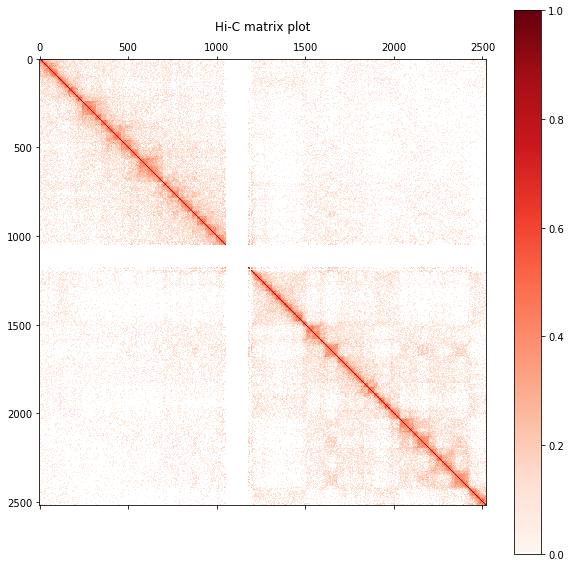

In [369]:
h.plot_matrix()

## 1.3 Sub-matrices

We want to reshape the matrix into N sub-matrices of size n*n*1 in order to create a  training and a test datasets to train and then test the Autoencoder.

In [370]:
n = 60
h.set_sub_matrices(n, n)

In [371]:
h.print_sub_matrices_informations()

1764 sub-matrices of shape : 60*60*1


10 random sub-matrices :


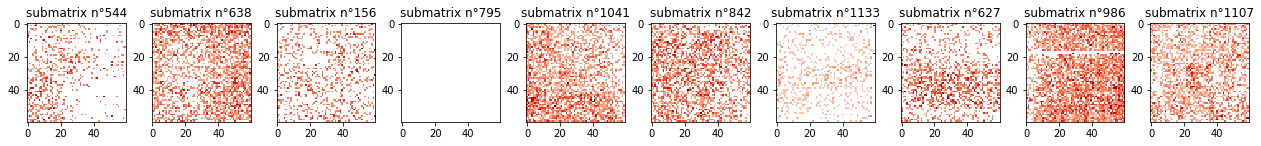

In [372]:
h.plot_ten_sub_matrices()

In [373]:
h.remove_white_sub_matrices()

In [374]:
h.print_sub_matrices_informations()

1681 sub-matrices of shape : 60*60*1


10 random sub-matrices :


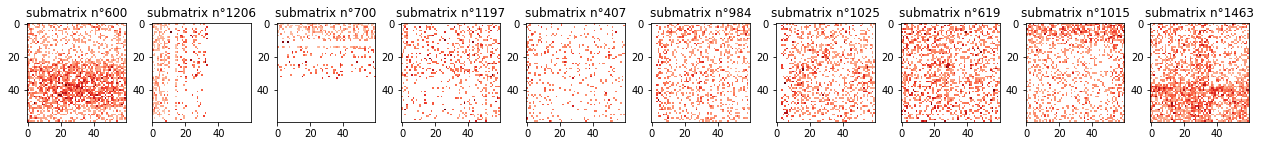

In [375]:
h.plot_ten_sub_matrices()

## 1.4 Data sets

In [398]:
def display_shape(name, dataset):
    print("{} : {} sub-matrices of shape {}*{}*{}"
        .format(name, dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3]))

### Train and test sets

In [396]:
random_index = rd.sample(range(0, h.sub_matrices.shape[0]), h.sub_matrices.shape[0])
sep = 1500

train = h.sub_matrices[random_index[:sep]]
test = h.sub_matrices[random_index[sep:]]

In [397]:
display_shape("Training set", train)
display_shape("Test set", test)

Training set : 1500 sub-matrices of shape 60*60*1
Test set : 181 sub-matrices of shape 60*60*1


### Split the training set into train_X (= 80% of the data) and valid_X (= 20% of the data) sets

In [399]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train,
                                                             train, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [400]:
display_shape("Train set", train_X)
display_shape("Validation set", valid_X)

Train set : 1200 sub-matrices of shape 60*60*1
Validation set : 300 sub-matrices of shape 60*60*1


## 2. Implementation of the Autoencoder

In [401]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import h5py

## 2.1 Parameters and building of the Model

In [402]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = n, n
input_img = Input(shape = (x, y, inChannel))

In [403]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #60 x 60 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 60 x 60 x 1
    return decoded

In [404]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [405]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

## 2.2 Train the model

In [406]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 18s 15ms/step - loss: 0.0343 - val_loss: 0.0097
Epoch 2/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 3/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 4/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 5/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 6/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 7/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 8/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 9/50
1200/1200 [==============================] - 23s 20ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 10/50
1200/

## 2.3 Training and Validation Loss Plot

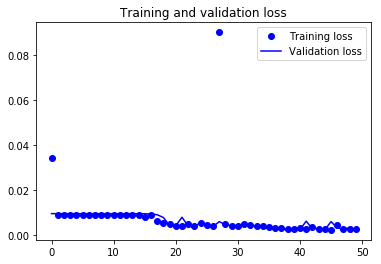

In [407]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [408]:
pred = autoencoder.predict(test)

In [409]:
display_shape("Test set", test)
display_shape("Pred set", pred)

Test set : 181 sub-matrices of shape 60*60*1
Pred set : 181 sub-matrices of shape 60*60*1


In [434]:
def plot_ten_submatrices(dataset):
    plt.figure(figsize=(22, 4))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        # img_random = rd.randint(0, h.sub_matrices.shape[0])
        plt.imshow(dataset[i, ..., 0], cmap=newcmp)
        plt.title("submatrix n°{}".format(i))

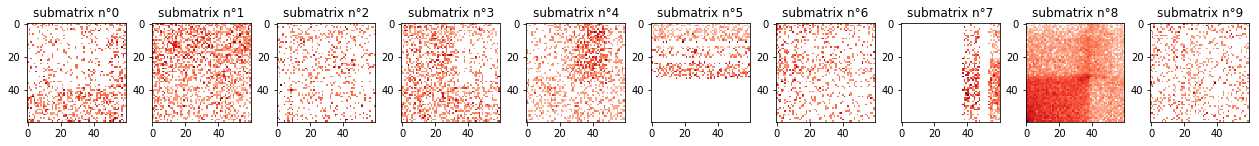

In [435]:
plot_ten_submatrices(test)

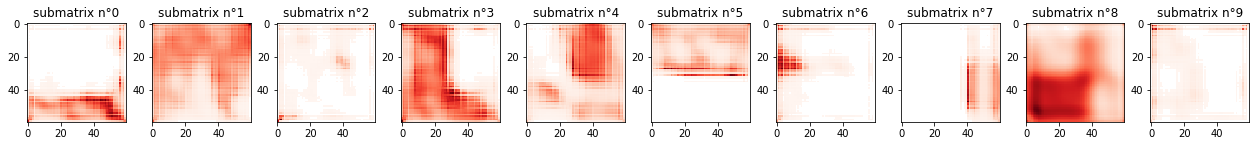

In [436]:
plot_ten_submatrices(pred)